In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-08-25 14:46:55.207409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")
#vueltas.drop(['Piloto'], axis = 1, inplace = True)
vueltas.drop(['nextPit'], axis = 1, inplace = True)
vueltas.drop(['makeStop'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020])]
vueltas_validation = vueltas[vueltas['anyo'].isin([2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

vueltas_test = vueltas_test[vueltas_test['Piloto'] == "max_verstappen"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_validation = vueltas_validation.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
#vueltas_test = vueltas_test.drop(['Stint'], axis=1)
vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
vueltas_validation.drop(['Piloto'], axis = 1, inplace = True)
vueltas_test.drop(['Piloto'], axis = 1, inplace = True)



vueltas_train = vueltas_train.astype(float)
vueltas_validation = vueltas_validation.astype(float)
vueltas_test = vueltas_test.astype(float)

In [39]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)
vueltas_validation_scaler = scaler.transform(vueltas_validation)

In [40]:
trainX = []
trainY = []
testX = []
testY = []
validationX = []
validationY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])
    
for i in range (loopback, len(vueltas_validation_scaler) -future +1):
    validationX.append(vueltas_validation_scaler[i-loopback:i, 0:vueltas_validation.shape[1]])
    validationY.append(vueltas_validation_scaler[i + future - 1:i + future,5])


In [41]:
trainX, trainY, testX, testY, validationX, validationY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY), np.array(validationX), np.array(validationY)

In [42]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 256)           281600    
                                                                 
 dropout_4 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 478,849
Trainable params: 478,849
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
48/48 [==============================] - 5s 53ms/step - loss: 0.0379
Epoch 2/12
48/48 [==============================] - 2s 38ms/step - loss: 0.0170
Epoch 3/12
48/48 [==============================] - 2s 49ms/step - loss: 0.0142
Epoch 4/12
48/48 [==============================] - 2s 44ms/step - loss: 0.0127
Epoch 5/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0113
Epoch 6/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0102
Epoch 7/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0098
Epoch 8/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0094
Epoch 9/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0090
Epoch 10/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0090
Epoch 11/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0084
Epoch 12/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0085


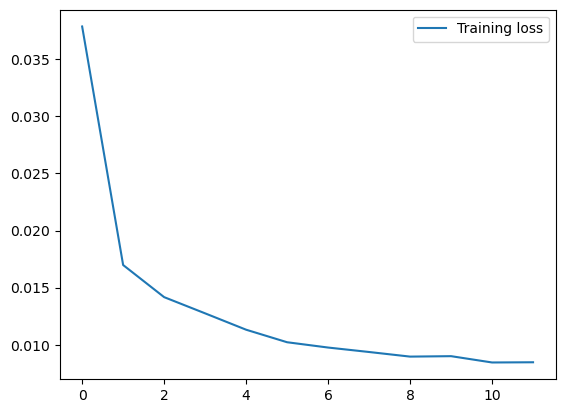

In [43]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [44]:
clases = np.unique(trainY[:,0]) #Cuidado de donde sacamos las clases, deberiamos sacarlas de train, 
#pero si en 2021 hubo una parada mas por lo que sea, falla lo de abajo, lo he hecho con validationY pero
# y si hace una menos en validation?
clases

#Por ejemplo en arabia saudi solo hubo 3 paradas, por lo cual es 0, 0,5 y 1. Si en validation hay 5,
#ya no coinciden, es decir, no las va a predecir, que es lo que hablamos la semana anterior


array([0.        , 0.33333333, 0.66666667, 1.        ])

In [45]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(validationY[:,0])

In [46]:
#AQUI ES CON LOS DATOS DE VALIDADACION
predictions = model.predict(validationX)

32/32 [==============================] - 1s 9ms/step


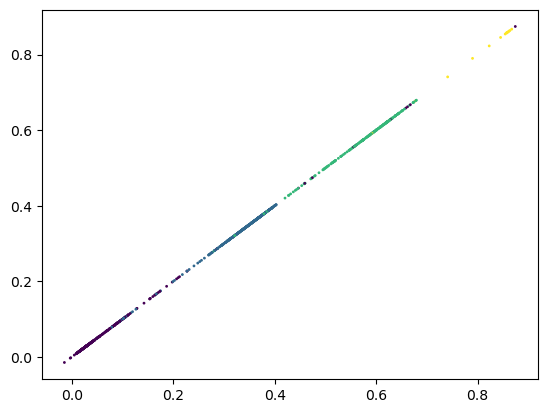

In [47]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [48]:
y_real_train = f(trainY[:,0])

In [49]:
predictions_test = model.predict(testX)

2/2 [==============================] - 0s 9ms/step


In [50]:
y_real_test =  f(testY[:,0])

In [51]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [52]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, y_real) # Esto es de validacion

In [53]:
pred_test_2 = rl.predict(predictions_test)

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_real_test, pred_test_2)
metricas = classification_report(y_real_test, pred_test_2)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(cm)
print(metricas)

[[ 2  0  0  0]
 [ 2 13  0  0]
 [ 0 16  0  0]
 [ 0  1 20  0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.43      0.87      0.58        15
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        21

    accuracy                           0.28        54
   macro avg       0.23      0.47      0.31        54
weighted avg       0.14      0.28      0.19        54

